In [1]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.5 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5dx6zk2q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5dx6zk2q
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import torch
import torchvision.transforms as T

#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [3]:
#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()

cfg.MODEL.DEVICE = "cpu"
# load the pre trained model from Detectron2 model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# set confidence threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# load model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# create the predictor for pose estimation using the config
pose_detector = DefaultPredictor(cfg)

[12/01 02:06:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


model_final_a6e10b.pkl: 237MB [00:01, 137MB/s]                           


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:

# Step 4: Add keypoint names and flip map to metadata
keypoint_names = ["wheel_1", "wheel_2", "mirror"]  # Example keypoint names (customize for your case)
keypoint_flip_map = [("wheel_1", "wheel_2")]  # Flip map for symmetrical keypoints

In [6]:
train_zip_path = "/content/Training.zip"
test_zip_path =  "/content/Testing.zip"
val_zip_path = "/content/Validation.zip"

In [7]:
train_dest = "/content/train_dataset/"
test_dest = "/content/test_dataset/"
val_dest = "/content/val_dataset/"

In [8]:
# Create destination directories
os.makedirs(train_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)
os.makedirs(val_dest, exist_ok=True)


In [9]:
!unzip -o "{train_zip_path}" -d "{train_dest}"
!unzip -o "{test_zip_path}" -d "{test_dest}"
!unzip -o "{val_zip_path}" -d "{val_dest}"

Archive:  /content/Training.zip
   creating: /content/train_dataset/Training/
   creating: /content/train_dataset/Training/.exports/
  inflating: /content/train_dataset/Training/.exports/coco-1731718545.7823513.json  
  inflating: /content/train_dataset/Training/.exports/coco-1731722087.9055562.json  
   creating: /content/train_dataset/Training/.thumbnail/
  inflating: /content/train_dataset/Training/.thumbnail/training (1).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (10).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (100).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (101).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (102).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (103).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (104).jpg  
  inflating: /content/train_dataset/Training/.thumbnail/training (105).jpg  
  inflating: /content/train

In [10]:
# Fix the image paths in both the Train and Test JSON files
train_json_file_path = '/content/Training-32.json'
test_json_file_path = '/content/Testing-34.json'
val_json_file_path = '/content/Validation-33.json'
updated_train_json_file_path = '/content/train_dataset-15-updated.json'
updated_test_json_file_path = '/content/test_dataset-16-updated.json'
updated_val_json_file_path = '/content/val_dataset-17-updated.json'

# Load and update the train JSON file
with open(train_json_file_path, 'r') as file:
    train_dataset = json.load(file)

for image_data in train_dataset['images']:
    image_data['file_name'] = image_data['file_name'].replace('/datasets/Training/', '/content/train_dataset/Training/')

# Save the updated train JSON
with open(updated_train_json_file_path, 'w') as file:
    json.dump(train_dataset, file)

# Load and update the test JSON file
with open(test_json_file_path, 'r') as file:
    test_dataset = json.load(file)

for image_data in test_dataset['images']:
    image_data['file_name'] = image_data['file_name'].replace('/datasets/Testing/', '/content/test_dataset/Testing/')

# Save the updated test JSON
with open(updated_test_json_file_path, 'w') as file:
    json.dump(test_dataset, file)


with open(val_json_file_path, 'r') as file:
    val_dataset = json.load(file)

for image_data in val_dataset['images']:
    image_data['file_name'] = image_data['file_name'].replace('/datasets/Validation/', '/content/val_dataset/Validation/')

with open(updated_val_json_file_path, 'w') as file:
    json.dump(val_dataset, file)

In [11]:
# Step 7: Register Datasets
from detectron2.data.datasets import register_coco_instances
register_coco_instances(
    "keypoint_train",
    {},
    updated_train_json_file_path,
    "/content/train_dataset/Training"
)

register_coco_instances(
    "keypoint_test",
    {},
    updated_test_json_file_path,
    "/content/test_dataset/Testing"
)

register_coco_instances(
    "keypoint_val",
    {},
    updated_val_json_file_path,
    "/content/val_dataset/Validation"
)


In [12]:
# Load the metadata for training dataset
train_metadata = MetadataCatalog.get("keypoint_train").set(keypoint_names = keypoint_names,keypoint_flip_map = keypoint_flip_map)
# Load the metadata for testing dataset
test_metadata = MetadataCatalog.get("keypoint_test").set(keypoint_names = keypoint_names,keypoint_flip_map = keypoint_flip_map)
val_metadata = MetadataCatalog.get("keypoint_val").set(keypoint_names = keypoint_names,keypoint_flip_map = keypoint_flip_map)

In [13]:
# Define the data augmentation and normalization transformations
def get_transform(train=True):
    transforms = []
    if train:
        # Data augmentation for training images
        transforms.append(T.RandomHorizontalFlip(prob=0.5))  # Random horizontal flip
        transforms.append(T.RandomRotation(degrees=15))  # Random rotation (15 degrees)
        transforms.append(T.RandomResizedCrop(224))  # Random resized crop
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2))  # Color jitter

    # Normalization: Using ImageNet's mean and std as an example
    transforms.append(T.ToTensor())  # Convert image to Tensor
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))  # Normalize

    return T.Compose(transforms)

In [14]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Initialize the configuration
cfg = get_cfg()

# Load a COCO-based config for keypoint detection
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))

# Set up your training dataset and testing dataset
cfg.DATASETS.TRAIN = ("keypoint_train",)
cfg.DATASETS.TEST = ("keypoint_test",)
cfg.DATASETS.VAL = ("keypoint_val",)

# Set the number of workers (you can adjust depending on resources)
cfg.DATALOADER.NUM_WORKERS = 2

# Set the number of classes for the classification task (1 class 'person')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Assuming only 'person'

# Set the number of keypoints (e.g., nose, eyes, hands, feet, etc.)
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3  # For your keypoints: nose, eyes, hands, feet

# Set the path to model weights from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# Set the batch size and iterations
cfg.SOLVER.IMS_PER_BATCH = 2  # You can adjust this depending on the GPU
cfg.SOLVER.BASE_LR = 0.00025  # Base learning rate
cfg.SOLVER.MAX_ITER = 100 # Number of iterations (adjust as per dataset size)
cfg.SOLVER.STEPS = []  # No learning rate decay

# Number of instances to process per image
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Directory to save model outputs
cfg.OUTPUT_DIR = "./output"

# Make sure the model runs on GPU
cfg.MODEL.DEVICE = "cuda"

# Create the output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [15]:

# Initialize trainer
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Start training
trainer.train()





[12/01 02:06:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[12/01 02:06:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Tr

[12/01 02:07:15 d2.utils.events]:  eta: 0:01:18  iter: 19  total_loss: 9.142  loss_cls: 0.7428  loss_box_reg: 0.2414  loss_keypoint: 8.099  loss_rpn_cls: 0.04543  loss_rpn_loc: 0.01253    time: 1.0185  last_time: 0.8064  data_time: 0.5507  last_data_time: 0.4130   lr: 4.7703e-05  max_mem: 2418M
[12/01 02:07:40 d2.utils.events]:  eta: 0:00:59  iter: 39  total_loss: 8.458  loss_cls: 0.1379  loss_box_reg: 0.2022  loss_keypoint: 8.034  loss_rpn_cls: 0.02047  loss_rpn_loc: 0.0105    time: 1.0451  last_time: 1.2486  data_time: 0.6036  last_data_time: 0.8339   lr: 9.7653e-05  max_mem: 2418M
[12/01 02:08:01 d2.utils.events]:  eta: 0:00:40  iter: 59  total_loss: 8.182  loss_cls: 0.0932  loss_box_reg: 0.1786  loss_keypoint: 7.864  loss_rpn_cls: 0.01308  loss_rpn_loc: 0.009657    time: 1.0597  last_time: 0.9067  data_time: 0.6401  last_data_time: 0.5161   lr: 0.0001476  max_mem: 2418M
[12/01 02:08:25 d2.utils.events]:  eta: 0:00:20  iter: 79  total_loss: 7.224  loss_cls: 0.06706  loss_box_reg: 0.

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import numpy as np

# Initialize the evaluator for the test dataset
evaluator = COCOEvaluator("keypoint_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "keypoint_test")

# Set KEYPOINT_OKS_SIGMAS to match the number of keypoints
# The error message indicates your model and ground truth have 3 keypoints,
# but cfg.TEST.KEYPOINT_OKS_SIGMAS has length 17.
# Change it to 3 to match your model and data.
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones(3, dtype=float).tolist()


# Perform inference on the test dataset and evaluate
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

WARNING [12/01 02:09:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/01 02:09:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/01 02:09:54 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/test_dataset-16-updated.json
[12/01 02:09:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/01 02:09:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/01 02:09:54 d2.data.common]: Serializing 23 elements to byte tensors and concatenating them all ...
[12/01 02:09:54 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/01 02:09:54 d2.evaluation.evaluator]: Start inference on 23 batches
[12/01 02:09:58 d2.evaluation.evaluat

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Build the data loaders for validation and test sets
val_loader = build_detection_test_loader(cfg, "keypoint_val")  # For validation
test_loader = build_detection_test_loader(cfg, "keypoint_test") # For test

# Perform evaluation on the validation set
val_results = inference_on_dataset(trainer.model, val_loader, COCOEvaluator("keypoint_val", cfg, False, output_dir="./output/"))
print("Validation Results:", val_results)

# Perform evaluation on the test set
test_results = inference_on_dataset(trainer.model, test_loader, COCOEvaluator("keypoint_test", cfg, False, output_dir="./output/"))
print("Test Results:", test_results)

WARNING [12/01 02:12:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/01 02:12:52 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/val_dataset-17-updated.json
[12/01 02:12:52 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    car     | 22           |
|            |              |
[12/01 02:12:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/01 02:12:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/01 02:12:52 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[12/01 02:12:52 d2.data.common]: Serialized dataset takes 0.01 MiB
WARNING [12/01 02:12:52 d2.data.datasets.coco]: 
Category ids in annotations a

[12/01 02:13:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

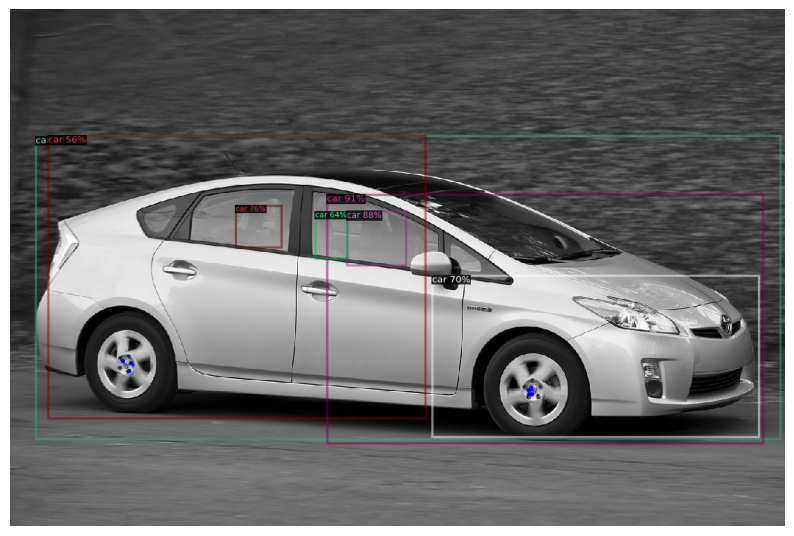

In [19]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
import requests # import requests module to handle URLs
from io import BytesIO # import BytesIO for in-memory file handling
import numpy as np # import numpy for array operations

# Set model weights for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for prediction
predictor = DefaultPredictor(cfg)

# Load a test image from URL using requests
image_path = "https://th.bing.com/th/id/R.b8a9de7082a3956d82709b98f027ead7?rik=pNCGqoiOktdoKw&riu=http%3a%2f%2f1.bp.blogspot.com%2f-eCuIYtlwsXE%2fUT9YnV_rl0I%2fAAAAAAAAKa0%2f9_42b83zCEg%2fs1600%2ftoyota%2bprius_5.jpg&ehk=r9g324oWg6vdv%2bx1LJywew30RZVHVqKkQNCrZDSGsWc%3d&risl=&pid=ImgRaw&r=0"
response = requests.get(image_path, stream=True)
response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
image = np.asarray(bytearray(response.content), dtype="uint8") # Convert content to bytearray
im = cv2.imdecode(image, cv2.IMREAD_COLOR) # Decode image data using cv2.imdecode

# Run inference
outputs = predictor(im)

# Visualize the result
v = Visualizer(im[:, :, ::-1], metadata=train_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

In [20]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Initialize the configuration
cfg = get_cfg()

# Load a COCO-based config for keypoint detection
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))

# Set up your training dataset and testing dataset
cfg.DATASETS.TRAIN = ("keypoint_train",)
cfg.DATASETS.TEST = ("keypoint_test",)
cfg.DATASETS.VAL = ("keypoint_val",)

# Set the number of workers (you can adjust depending on resources)
cfg.DATALOADER.NUM_WORKERS = 2

# Set the number of classes for the classification task (1 class 'person')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Assuming only 'person'

# Set the number of keypoints (e.g., nose, eyes, hands, feet, etc.)
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3  # For your keypoints: nose, eyes, hands, feet

# Set the path to model weights from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# Set the batch size and iterations
cfg.SOLVER.IMS_PER_BATCH = 2  # You can adjust this depending on the GPU
cfg.SOLVER.BASE_LR = 0.00025  # Base learning rate
cfg.SOLVER.MAX_ITER = 2500 # Number of iterations (adjust as per dataset size)
cfg.SOLVER.STEPS = []  # No learning rate decay

# Number of instances to process per image
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Directory to save model outputs
cfg.OUTPUT_DIR = "/content/model_final.pth/"

# Make sure the model runs on GPU
cfg.MODEL.DEVICE = "cuda"

# Create the output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [21]:
# Initialize trainer
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Start training
trainer.train()


[12/01 02:13:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[12/01 02:13:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[12/01 02:13:58 d2.utils.events]:  eta: 0:37:57  iter: 19  total_loss: 9.207  loss_cls: 0.7969  loss_box_reg: 0.2138  loss_keypoint: 8.07  loss_rpn_cls: 0.04819  loss_rpn_loc: 0.01331    time: 0.9906  last_time: 0.6803  data_time: 0.5493  last_data_time: 0.2632   lr: 4.9953e-06  max_mem: 3102M
[12/01 02:14:17 d2.utils.events]:  eta: 0:37:27  iter: 39  total_loss: 9.02  loss_cls: 0.652  loss_box_reg: 0.2235  loss_keypoint: 8.064  loss_rpn_cls: 0.03881  loss_rpn_loc: 0.01152    time: 0.9528  last_time: 0.5000  data_time: 0.4454  last_data_time: 0.0107   lr: 9.9902e-06  max_mem: 3103M
[12/01 02:14:37 d2.utils.events]:  eta: 0:37:02  iter: 59  total_loss: 8.715  loss_cls: 0.4204  loss_box_reg: 0.1911  loss_keypoint: 8.052  loss_rpn_cls: 0.03688  loss_rpn_loc: 0.009382    time: 0.9818  last_time: 1.2842  data_time: 0.5449  last_data_time: 0.7847   lr: 1.4985e-05  max_mem: 3103M
[12/01 02:14:56 d2.utils.events]:  eta: 0:36:18  iter: 79  total_loss: 8.474  loss_cls: 0.1928  loss_box_reg: 0.17

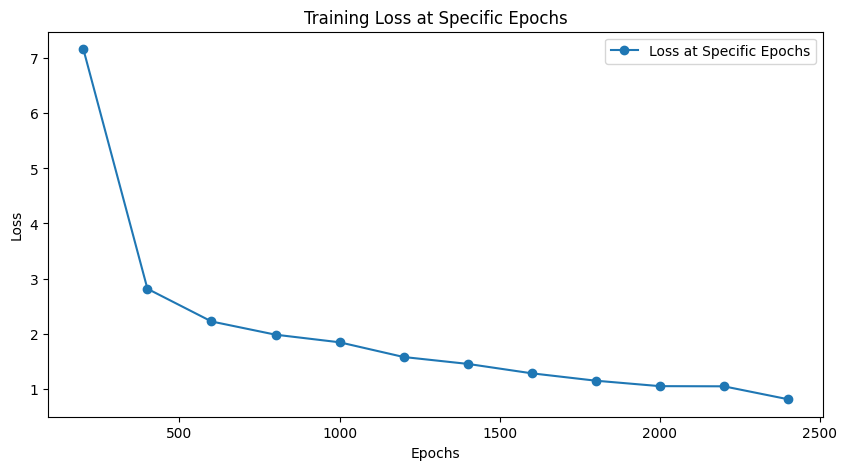

In [30]:
# Extract the epoch numbers and corresponding losses for plotting
import matplotlib.pyplot as plt
epochs = [200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400]
losses=[7.163,2.815,2.222,1.982,1.844,1.577,1.452,1.281,1.147,1.048,1.045,0.8107]

# Plotting the collected loss values
plt.figure(figsize=(10, 5))

plt.plot(epochs, losses, label='Loss at Specific Epochs', marker='o')

# Adding titles and labels
plt.title('Training Loss at Specific Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [24]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import numpy as np

# Initialize the evaluator for the test dataset
evaluator = COCOEvaluator("keypoint_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "keypoint_test")

# Set KEYPOINT_OKS_SIGMAS to match the number of keypoints
# The error message indicates your model and ground truth have 3 keypoints,
# but cfg.TEST.KEYPOINT_OKS_SIGMAS has length 17.
# Change it to 3 to match your model and data.
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones(3, dtype=float).tolist()


# Perform inference on the test dataset and evaluate
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

WARNING [12/01 02:55:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/01 02:55:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/01 02:55:20 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/test_dataset-16-updated.json
[12/01 02:55:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/01 02:55:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/01 02:55:20 d2.data.common]: Serializing 23 elements to byte tensors and concatenating them all ...
[12/01 02:55:20 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/01 02:55:20 d2.evaluation.evaluator]: Start inference on 23 batches
[12/01 02:55:25 d2.evaluation.evaluat

In [25]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Build the data loaders for validation and test sets
val_loader = build_detection_test_loader(cfg, "keypoint_val")  # For validation
test_loader = build_detection_test_loader(cfg, "keypoint_test") # For test

# Perform evaluation on the validation set
val_results = inference_on_dataset(trainer.model, val_loader, COCOEvaluator("keypoint_val", cfg, False, output_dir="./output/"))
print("Validation Results:", val_results)

# Perform evaluation on the test set
test_results = inference_on_dataset(trainer.model, test_loader, COCOEvaluator("keypoint_test", cfg, False, output_dir="./output/"))
print("Test Results:", test_results)

WARNING [12/01 02:55:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/01 02:55:48 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/val_dataset-17-updated.json
[12/01 02:55:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/01 02:55:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/01 02:55:48 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[12/01 02:55:48 d2.data.common]: Serialized dataset takes 0.01 MiB
WARNING [12/01 02:55:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/01 02:55:48 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/test_dataset-16-updated.json
[12/01 02:55:48 d2.data.dat

In [28]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [29]:
import gradio as gr
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import numpy as np

# Set model weights for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for prediction
predictor = DefaultPredictor(cfg)

def predict_keypoints(image):
    """
    Performs keypoint detection on the input image and returns the visualized output.
    """
    # Run inference
    outputs = predictor(image)

    # Visualize the result
    v = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Convert the output image to NumPy array for Gradio
    output_image = out.get_image()[:, :, ::-1]
    return output_image

# Create a Gradio interface
iface = gr.Interface(
    fn=predict_keypoints,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="Keypoint Detection",
    description="Upload an image to detect keypoints.",
)

# Launch the interface
iface.launch()

[12/01 02:57:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/model_final.pth/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfb2e19ff2c2c84d67.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
